# Image Decoder examples (CPU)

In this notebook we will show usage examples of different flavors of `decoders.image` for CPU backend.

## Common code

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1549361629

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

image_dir = "../data/images"
batch_size = 4

## Image Decoder (CPU)

`decoders.image` decodes images stored in common formats (including JPEG, JPEG2000, TIFF, PNG)

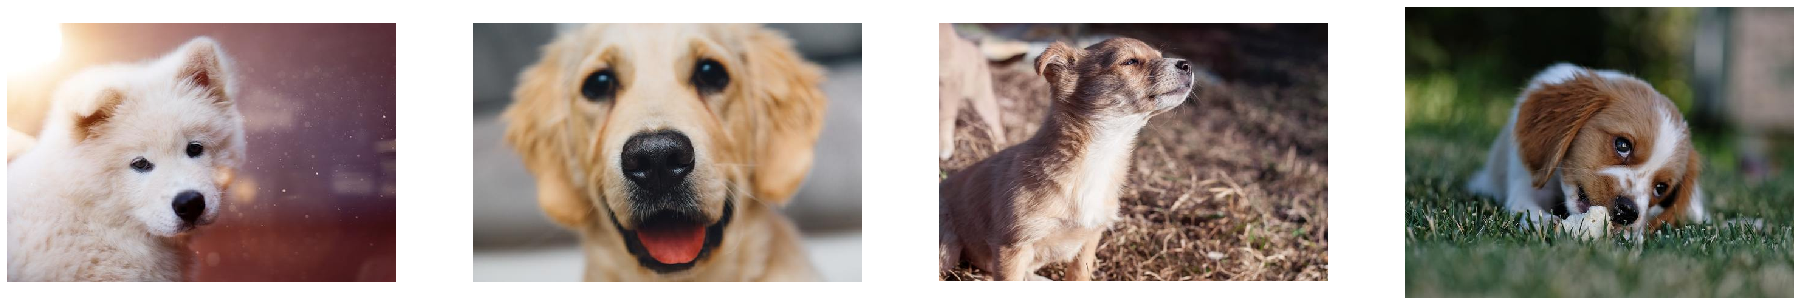

In [2]:
@pipeline_def(seed=seed)
def image_decoder_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir)
    return fn.decoders.image(jpegs)
    
pipe = image_decoder_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images)

## Image Decoder (CPU) with Random Cropping Window Size and Anchor

`decoders.image_random_crop` produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

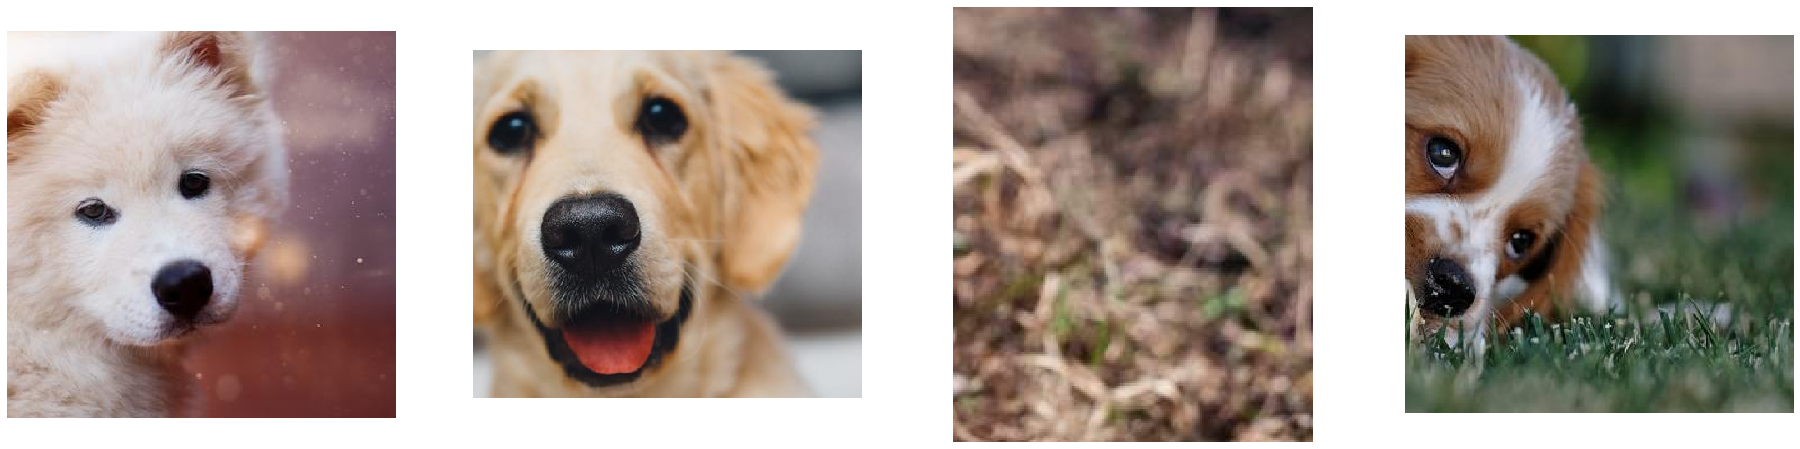

In [3]:
@pipeline_def(seed=seed)
def image_decoder_random_crop_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir)
    images = fn.decoders.image_random_crop(jpegs,
                                           random_aspect_ratio=[0.8, 1.25],
                                           random_area=[0.1, 1.0],
                                           num_attempts=100)
    return images
    
pipe = image_decoder_random_crop_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images)

## Image Decoder with Fixed Cropping Window Size and External Anchor

`decoders.image_crop` produces a cropped image with a fixed cropping window size and a variable position

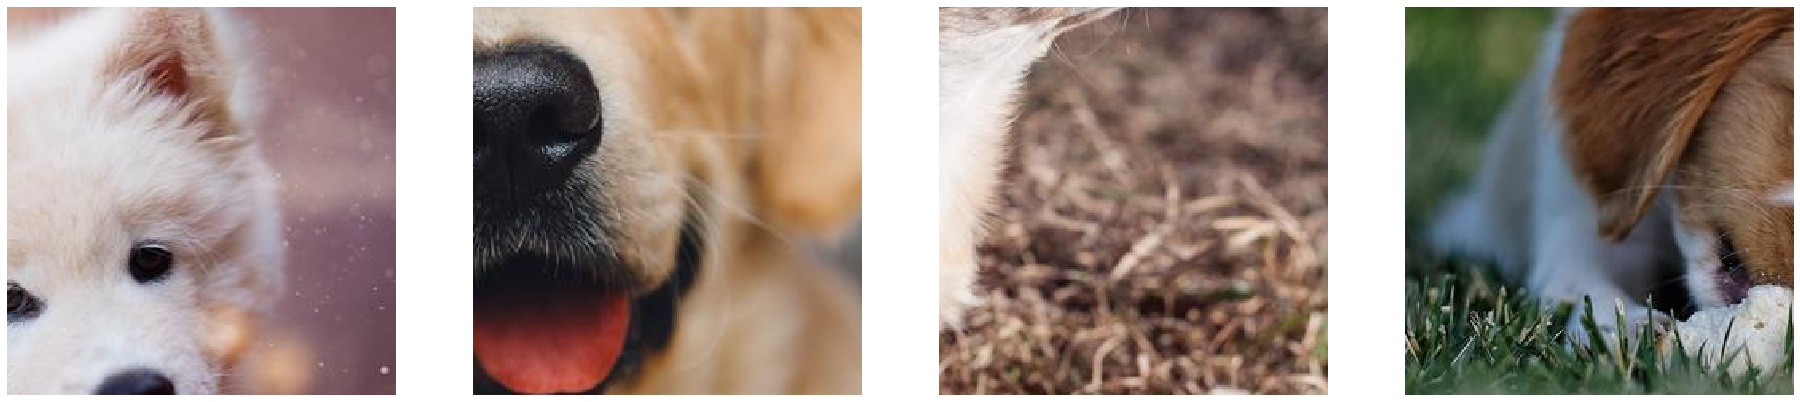

In [4]:
@pipeline_def(seed=seed)
def image_decoder_crop_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir)
    pos_x = fn.random.uniform(range=(0., 1.))
    pos_y = fn.random.uniform(range=(0., 1.))
    return fn.decoders.image_crop(jpegs, crop=(244, 244), crop_pos_x=pos_x, crop_pos_y=pos_y)

pipe = image_decoder_crop_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images)

## Image Decoder (CPU) with External Window Size and Anchor

`decoders.image_slice` produces a cropped image based on additional tensor inputs describing the cropping window size and position

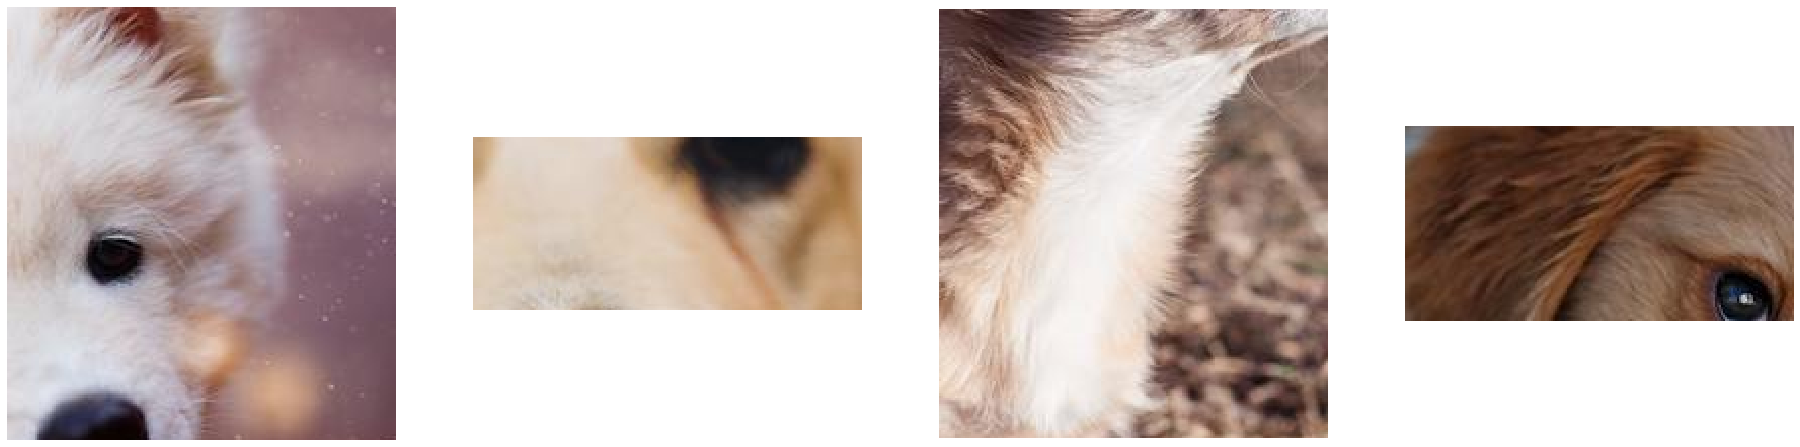

In [5]:
import numpy as np
from itertools import product

pos_source = [[0.4, 0.2], [0.3, 0.3]]
size_source = [[0.3, 0.5], [0.3, 0.2]]

def ext_source_generator():
    for pos, size in product(pos_source, size_source):
        yield np.array(pos, dtype=np.float32), np.array(size, dtype=np.float32)
        
@pipeline_def(seed=seed)
def image_decoder_slice_pipeline():
    crop_pos, crop_size = fn.external_source(source=ext_source_generator, cycle=True,
                                             num_outputs=2, batch=False)
    jpegs, labels = fn.readers.file(file_root=image_dir)
    return fn.decoders.image_slice(jpegs, crop_pos, crop_size)

pipe = image_decoder_slice_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images)

# Image Decoder (Hybrid)

`decoders.image` with mixed backend offloads JPEG decoding to the GPU or a dedicated hardware unit, if present.

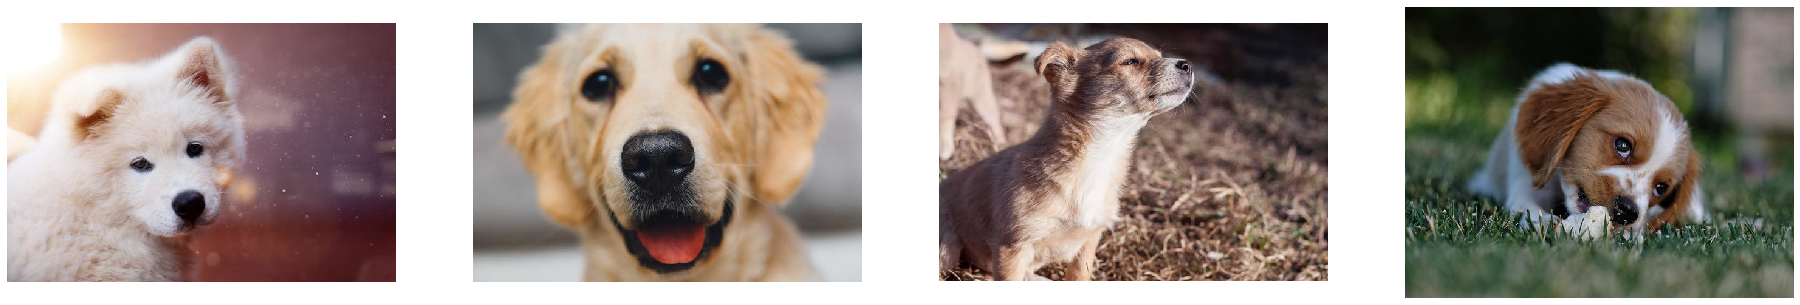

In [6]:
@pipeline_def(seed=seed)
def image_decoder_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir)
    return fn.decoders.image(jpegs, device='mixed')
    
pipe = image_decoder_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images.as_cpu())

## Image Decoder (Hybrid) with Random Cropping Window Size and Anchor

`decoders.image_random_crop` produces a randomly cropped image. The random cropping window is produced based on a given aspect ratio and area distributions.

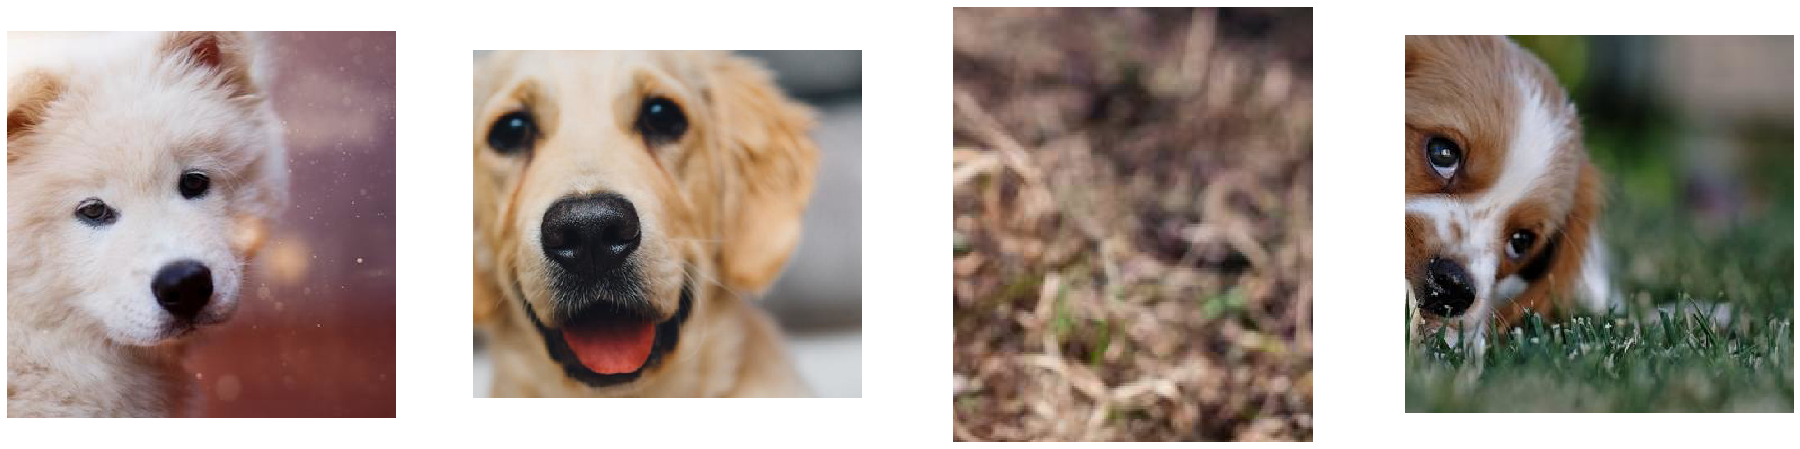

In [7]:
@pipeline_def(seed=seed)
def image_decoder_random_crop_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir)
    images = fn.decoders.image_random_crop(jpegs,
                                           random_aspect_ratio=[0.8, 1.25],
                                           random_area=[0.1, 1.0],
                                           num_attempts=100,
                                           device='mixed')
    return images
    
pipe = image_decoder_random_crop_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images.as_cpu())

## Image Decoder (Hybrid) with Fixed Cropping Window Size and External Anchor

`decoders.image_crop` produces a cropped image with a fixed cropping window size and a variable position


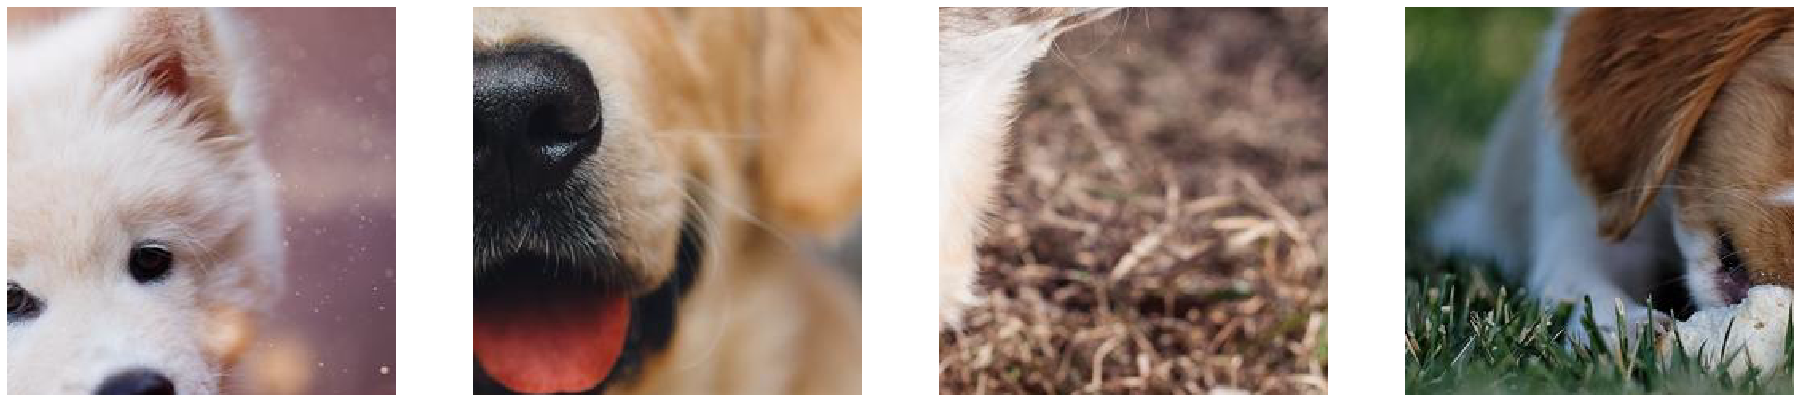

In [8]:
@pipeline_def(seed=seed)
def image_decoder_crop_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir)
    pos_x = fn.random.uniform(range=(0., 1.))
    pos_y = fn.random.uniform(range=(0., 1.))
    return fn.decoders.image_crop(jpegs, crop=(244, 244), crop_pos_x=pos_x, crop_pos_y=pos_y, device='mixed')

pipe = image_decoder_crop_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images.as_cpu())

## Image Decoder (Hybrid) with External Window Size and Anchor

`decoders.image_slice` produces a cropped image based on additional tensor inputs describing the cropping window size and position

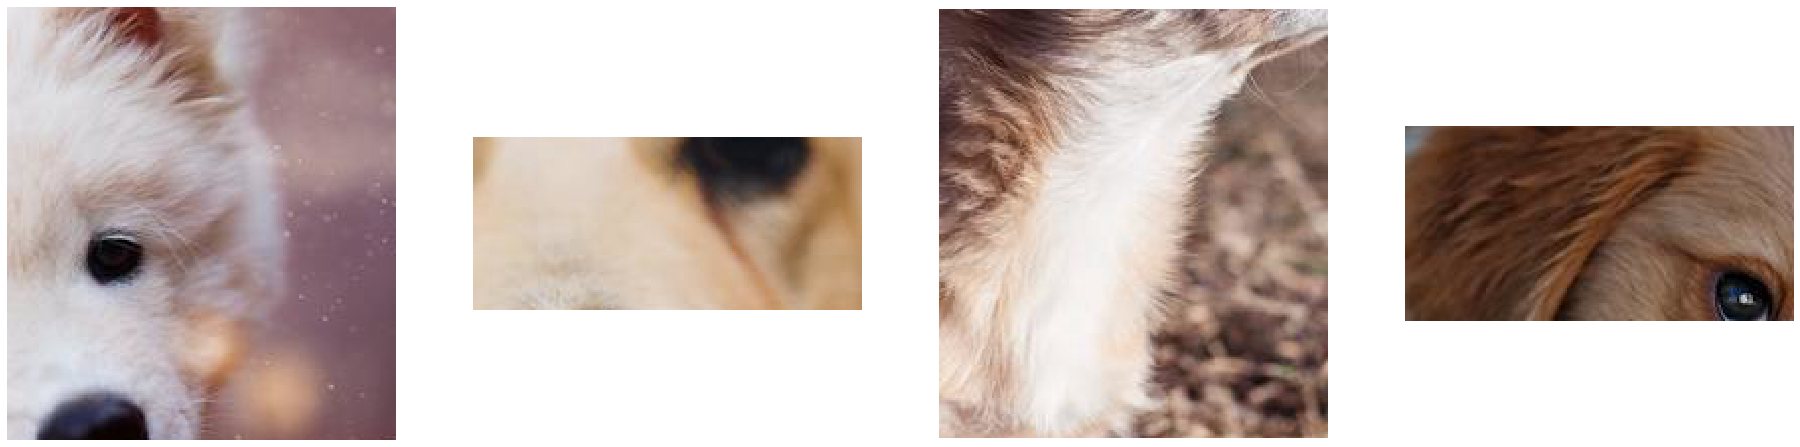

In [9]:
pos_source = [[0.4, 0.2], [0.3, 0.3]]
size_source = [[0.3, 0.5], [0.3, 0.2]]

def ext_source_generator():
    for pos, size in product(pos_source, size_source):
        yield np.array(pos, dtype=np.float32), np.array(size, dtype=np.float32)
        
@pipeline_def(seed=seed)
def image_decoder_slice_pipeline():
    crop_pos, crop_size = fn.external_source(source=ext_source_generator, cycle=True,
                                             num_outputs=2, batch=False)
    jpegs, labels = fn.readers.file(file_root=image_dir)
    return fn.decoders.image_slice(jpegs, crop_pos, crop_size, device='mixed')

pipe = image_decoder_slice_pipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
images, = pipe.run()
show_images(images.as_cpu())